# GraphViz Ensemble

In this notebook, we construct a graph of a chain of models.

## Preliminaries

In [1]:
import os
import sys
import networkx as nx

from os.path import dirname

note_dir = os.getcwd()

root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus
from morpheus.tests import default_chain, default_ensemble
from morpheus.graph import (model_to_graph,
                            model_graph_traces,
                            model_graph_layout, 
                            convert_positions_to_dot_format)

## Build Ensemble

In [2]:
chain = default_ensemble()


        Learning model with desc ids:    [0, 1, 2]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 3]
                            targ ids:    [4, 5]
        


In [3]:
chain.pretty_print()


        # Main
        Descriptive attributes:     [0. 1. 2. 3.]
        Target attributes:          [4. 5.]

        ## On types (mostly nominals)
        Target attribute types:                     ['numeric', 'numeric']
        N_classes of nominal target attributes:     []
        Classes of nominal target attributes:       []

        ## Weights
        Total weights of target attributes:         [1. 2.]

         
        ## Estimators
        Estimators used:        ['RandomForestRegressor', 'RandomForestRegressor']
        N_estimators:           2
        


## Build Graph

In [4]:
model_one = chain.estimators_[0]
model_two = chain.estimators_[1]

In [5]:
G_one = model_to_graph(model_one, idx=1)
G_two = model_to_graph(model_two, idx=2)

In [6]:
G_one.nodes()

NodeView(('d-0000', 'd-0001', 'd-0002', 'd-0005', 'f-0001'))

In [7]:
G_chain = nx.compose(G_one, G_two)

In [8]:
for n in G_chain.nodes():
    if G_chain.nodes()[n]['bipartite'] == 'func':
        G_chain.nodes()[n]['shape'] = "\"square\""
        G_chain.nodes()[n]['width'] = "2.5"
    else:
        G_chain.nodes()[n]['shape'] = "\"circle\""

## Build graph from ensemble

Now,we try to combine.

In [9]:
from networkx.drawing.nx_pydot import to_pydot

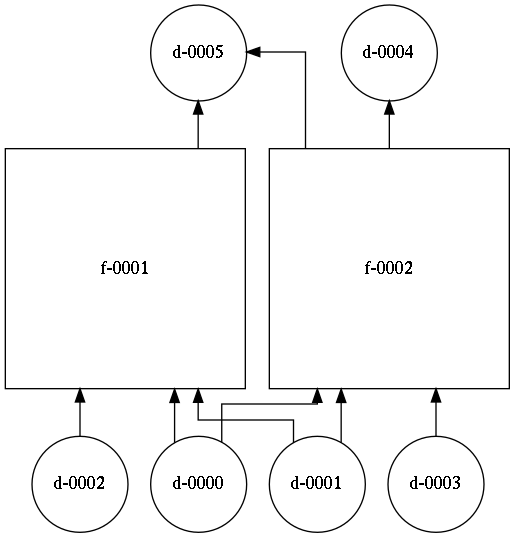

In [10]:
X = to_pydot(G_chain)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [11]:
G = G_chain.copy()

In [12]:
def add_merge_nodes(G):
    data_nodes = [n for n in G.nodes() if G.nodes()[n]['bipartite']=='data']
    
    mapping = {}
    for node in data_nodes:
        if len(G.in_edges(node)) > 1:
            mapping[node] = "merge-{}".format(node)
    
    nx.relabel_nodes(G, mapping, copy=False)
    
    return 

In [13]:
def convert_data_node_to_merge_node(G, data_node_label):
    assert G.nodes()[data_node_label]['bipartite'] == 'data'
    
    mapping = {}
    mapping[data_node_label] = "merge"
    
    nx.relabel_nodes(G, mapping, copy=False)
    
    G.nodes()[mapping[data_node_label]]['shape'] = "\"triangle\""
    
    return mapping[data_node_label]

In [14]:
def place_original_data_node_behind_merge_node(G, original_node, merge_node_label):
    
    G.add_node(original_node[0], **original_node[1])
    G.add_edge(merge_node_label, original_node[0], idx=original_node[1]['idx'])
    
    return G

In [15]:
def test(G, original_node_label):
    
    original_node_attributes = G.nodes(data=True)[original_node_label]
    
    original_node = (original_node_label, original_node_attributes)
    
    merge_node_label = convert_data_node_to_merge_node(G, original_node_label)
    place_original_data_node_behind_merge_node(G, original_node, merge_node_label)
    
    return

In [16]:
test(G, 'd-0005')

In [17]:
G.edges(data=True)

OutEdgeDataView([('d-0000', 'f-0001', {'idx': 0}), ('d-0000', 'f-0002', {'idx': 0}), ('d-0001', 'f-0001', {'idx': 1}), ('d-0001', 'f-0002', {'idx': 1}), ('d-0002', 'f-0001', {'idx': 2}), ('f-0001', 'merge', {'idx': 5}), ('d-0003', 'f-0002', {'idx': 3}), ('f-0002', 'd-0004', {'idx': 4}), ('f-0002', 'merge', {'idx': 5}), ('merge', 'd-0005', {'idx': 5})])

In [18]:
for e in G.edges():
    print(e)
    G.edges()[e]["xlabel"] = G.edges()[e]["idx"]

('d-0000', 'f-0001')
('d-0000', 'f-0002')
('d-0001', 'f-0001')
('d-0001', 'f-0002')
('d-0002', 'f-0001')
('f-0001', 'merge')
('d-0003', 'f-0002')
('f-0002', 'd-0004')
('f-0002', 'merge')
('merge', 'd-0005')


In [19]:
X = to_pydot(G)
X.set('rankdir', 'BT')
X.set('splines', 'ortho')

In [20]:
print(X.to_string())

strict digraph  {
rankdir=BT;
splines=ortho;
"d-0000" [bipartite=data, idx=0, shape="circle"];
"d-0001" [bipartite=data, idx=1, shape="circle"];
"d-0002" [bipartite=data, idx=2, shape="circle"];
"f-0001" [bipartite=func, idx=1, mod="RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,\n           max_features='auto', max_leaf_nodes=None,\n           min_impurity_decrease=0.0, min_impurity_split=None,\n           min_samples_leaf=1, min_samples_split=2,\n           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,\n           oob_score=False, random_state=None, verbose=0, warm_start=False)", shape="square", width="2.5"];
"d-0003" [bipartite=data, idx=3, shape="circle"];
"d-0004" [bipartite=data, idx=4, shape="circle"];
"f-0002" [bipartite=func, idx=2, mod="RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,\n           max_features='auto', max_leaf_nodes=None,\n           min_impurity_decrease=0.0, min_impurity_split=None,\n           min_samples_

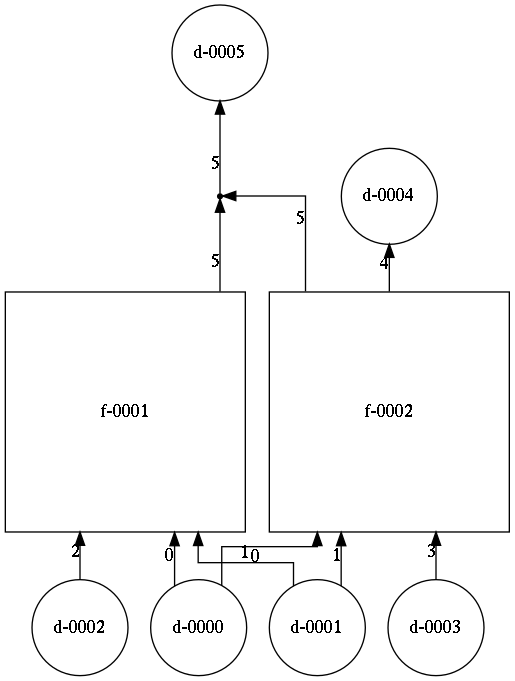

In [21]:
with open("test.dot", "w") as text_file:
    print(X.to_string(), file=text_file)
    
!dot -T png test.dot > test.png  # Bash command

from IPython.display import Image, display
from IPython.core.display import HTML 

display(Image('test.png', unconfined=True))

In [22]:
from graphviz import Graph

g = Graph('parent')

c = Graph('child')
c.attr(rank='same')
c.node('A')
c.node('B')
c.node('C')
c.edge('A', 'B') #without rank='same', B will be below A

g.subgraph(c)

print(g.source)

graph parent {
	subgraph child {
		rank=same
		A
		B
		C
		A -- B
	}
}
